### 0. Import libraries and load data

In [1]:
import os
import sys
import json
import h5py
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import keras.utils as image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, Conv2DTranspose

DATA_PATH = "../data/"
ENCODED_DATA_PATH = "../encoded_data/"
DATABASE_PATH = "database/database_lite.json"
QUERY_PATH = "query/query_lite.json"
SIMILARITY_FILE_NAME = "london_lite_gt.h5"


In [2]:
# map
with open(DATA_PATH + DATABASE_PATH, "r") as f:
    m_idx = json.load(f)
    m_imgs = np.array(m_idx["im_paths"])
    m_loc = np.array(m_idx["loc"])

# query
with open(DATA_PATH + QUERY_PATH, "r") as f:
    q_idx = json.load(f)
    q_imgs = np.array(q_idx["im_paths"])
    q_loc = np.array(q_idx["loc"])
    
# loading the relevance judgements
with h5py.File(DATA_PATH + SIMILARITY_FILE_NAME, "r") as f:
    fovs = f["fov"][:]
    sim = f["sim"][:].astype(np.uint8)


### 1. Pre-process images

In [3]:
def get_image_shapes(image_paths):
    image_shapes = set()

    for image_path in image_paths:
        img = plt.imread(os.path.join(DATA_PATH + image_path))
        image_shapes.add(img.shape)
        
    return image_shapes


In [4]:
def get_smallest_image_size(m_imgs_shapes, q_imgs_shapes):
    smallest_shape = None
    smallest_size = sys.maxsize
    imgs_shapes = q_imgs_shapes.union(m_imgs_shapes)

    for img_shape in imgs_shapes:
        image_size = img_shape[0] * img_shape[1] * img_shape[2]

        if image_size <= smallest_size:
            smallest_size = image_size
            smallest_shape = img_shape
            
    new_even_dims = []

    for dim_index in range(len(smallest_shape) - 1):
        if smallest_shape[dim_index] % 2 == 1:
            new_even_dims.append(smallest_shape[dim_index] - smallest_shape[dim_index] % 8)
        else:
            new_even_dims.append(smallest_shape[dim_index])

    smallest_shape_even = (new_even_dims[0], new_even_dims[1], smallest_shape[2])
    print(f"\nSmallest image shape with even sizes is: {smallest_shape_even}")

    return smallest_shape_even


In [5]:
m_imgs_shapes = get_image_shapes(m_imgs)
print(f"Shapes of database images:\n{m_imgs_shapes}")

q_imgs_shapes = get_image_shapes(q_imgs)
print(f"\nShapes of query images:\n{q_imgs_shapes}")

smallest_image_shape = get_smallest_image_size(m_imgs_shapes, q_imgs_shapes)


Shapes of database images:
{(256, 455, 3), (256, 341, 3), (256, 367, 3)}

Shapes of query images:
{(256, 341, 3), (256, 455, 3)}

Smallest image shape with even sizes is: (256, 336, 3)


In [6]:
def load_images(image_paths, image_size):
    preprocessed_images = np.zeros(
        (len(image_paths), image_size[0], image_size[1], image_size[2])
    )

    for index, image_path in enumerate(image_paths):
        raw_img = image.load_img(DATA_PATH + image_path)
        resized_img = tf.image.resize(raw_img, (image_size[0], image_size[1]))
        scaled_img = resized_img / 255
        array_img = image.img_to_array(scaled_img).astype("float32")
        preprocessed_images[index] = array_img
        
    return preprocessed_images


In [7]:
database_images = load_images(m_imgs, smallest_image_shape)
print(f"Shape of database dataset: {database_images.shape}")

query_images = load_images(q_imgs, smallest_image_shape)
print(f"Shape of query dataset: {query_images.shape}")


Shape of database dataset: (1000, 256, 336, 3)
Shape of query dataset: (500, 256, 336, 3)


In [8]:
def display_reshaped_image(database_images, m_imgs, image_index):
    fig, ax = plt.subplots(2, 1)
    fig.tight_layout()

    ax[0].imshow(plt.imread(os.path.join(DATA_PATH + m_imgs[image_index])))
    ax[0].set_title("Original image")

    ax[1].imshow(database_images[image_index])
    ax[1].set_title("Resized image")

    plt.show()


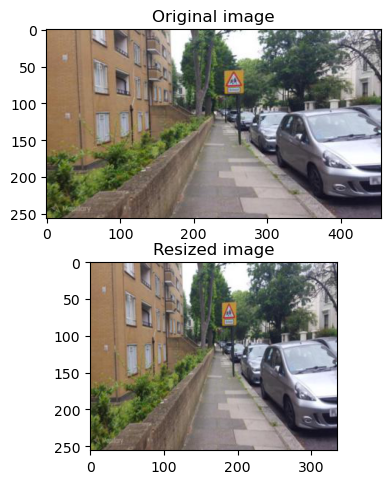

In [9]:
display_reshaped_image(database_images, m_imgs, image_index=6)


### 2. Optimize the autoencoder

In [10]:
def build_model(image_shape, learning_rate=0.001, display_architecture=False):
    input_layer = Input(shape=image_shape)   
    conv_1 = Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)(input_layer)
    conv_2 = Conv2D(16, (3, 3), activation='relu', padding='same', strides=2)(conv_1)
    conv_3 = Conv2D(32, (3, 3), activation='relu', padding='same', strides=2)(conv_2)
    bootleneck = Conv2D(38, (3, 3), activation='relu', padding='same', strides=2)(conv_3)

    conv_t_1 = Conv2DTranspose(38, kernel_size=3, strides=2, activation='relu', padding='same')(bootleneck)
    conv_t_2 = Conv2DTranspose(32, kernel_size=3, strides=2, activation='relu', padding='same')(conv_t_1)
    conv_t_3 = Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same')(conv_t_2)
    conv_t_4 = Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same')(conv_t_3)
    output_layer = Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')(conv_t_4)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    encoder = Model(inputs=input_layer, outputs=bootleneck)   

    autoencoder.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate))

    if display_architecture:
        print(autoencoder.summary())

    return autoencoder, encoder

In [11]:
def plot_loss_evolution(history, batch_size, learning_rate, show_image=True, save_image=False):
    fig, _ = plt.subplots(1, 1)

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])

    plt.title(f"Loss evolution - batch size {batch_size} | learning rate {learning_rate}")
    plt.legend(["Training", "Validation"])

    if show_image:
        plt.show()

    if save_image:
        fig.savefig(f'../results/batch_size_{batch_size}_learning_rate_{learning_rate}.png', dpi=300)

    if not show_image:
        plt.close()

In [12]:
def optimize_model():
    results = {"batch size": [], "learning rate": [], "train loss": [], "val loss": []}

    batch_sizes = [1, 16, 32, 64, 128]
    learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

    for batch_size in batch_sizes:
        for learning_rate in learning_rates:
            print(".", end="")
            
            autoencoder, _ = build_model(smallest_image_shape, learning_rate)

            history = autoencoder.fit(database_images, database_images, epochs=100, batch_size=batch_size, validation_split=0.1, shuffle=True, callbacks=[EarlyStopping(monitor='val_loss', patience=3)], verbose=0)

            plot_loss_evolution(history, batch_size, learning_rate, show_image=False, save_image=True)

            results["batch size"].append(batch_size)
            results["learning rate"].append(learning_rate)
            results["train loss"].append(history.history["loss"][-1])
            results["val loss"].append(history.history["val_loss"][-1])

            pd.DataFrame(results).to_csv("../results/optimization_results.csv", index=None)

In [13]:
# optimize_model()

### 3. Re-train the best autoencoder on all database images

In [14]:
optimization_results = pd.read_csv("../results/optimization_results.csv").sort_values("val loss")
optimization_results

,batch size,learning rate,train loss,val loss
1,1,0.0005,0.001690,0.002242
0,1,0.0001,0.002212,0.002611
7,16,0.0010,0.002520,0.002985
6,16,0.0005,0.002912,0.003226
3,1,0.0050,0.004063,0.004576
5,16,0.0001,0.004230,0.005119
4,1,0.0100,0.004987,0.005665
2,1,0.0010,0.005226,0.005876


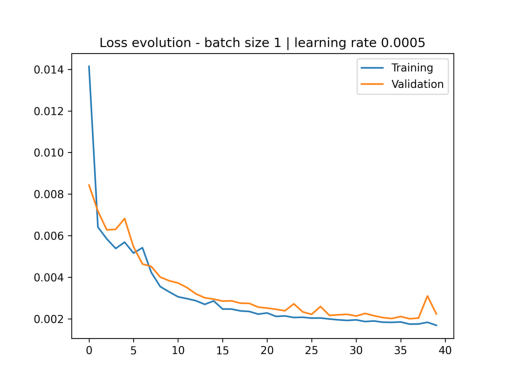

In [15]:
optimum_batch_size = int(optimization_results.iloc[0, 0])
optimum_learning_rate = optimization_results.iloc[0, 1]

loss_evolution = plt.imread(f"../results/batch_size_{optimum_batch_size}_learning_rate_{optimum_learning_rate}.png")

fig = plt.imshow(loss_evolution)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)

In [16]:
autoencoder, encoder = build_model(smallest_image_shape, learning_rate=optimum_learning_rate, display_architecture=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 336, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 168, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 84, 16)        1168      
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 42, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 21, 38)        10982     
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 42, 38)        13034     
 anspose)                                                        
                                                             

In [18]:
history = autoencoder.fit(database_images, database_images, epochs=10, batch_size=optimum_batch_size)

Epoch 1/10
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0090
Epoch 2/10
1000/1000 [==============================] - 53s 53ms/step - loss: 0.0065
Epoch 3/10
1000/1000 [==============================] - 56s 56ms/step - loss: 0.0060
Epoch 4/10
1000/1000 [==============================] - 58s 58ms/step - loss: 0.0064
Epoch 5/10
1000/1000 [==============================] - 55s 55ms/step - loss: 0.0053
Epoch 6/10
1000/1000 [==============================] - 65s 65ms/step - loss: 0.0041
Epoch 7/10
1000/1000 [==============================] - 57s 57ms/step - loss: 0.0037
Epoch 8/10
1000/1000 [==============================] - 58s 58ms/step - loss: 0.0035
Epoch 9/10
1000/1000 [==============================] - 54s 54ms/step - loss: 0.0034
Epoch 10/10
1000/1000 [==============================] - 64s 64ms/step - loss: 0.0033


### 4. Visualize reconstructed images

In [19]:
def display_reconstructed_images(autoencoder, database_images, query_images):
    fig, ax = plt.subplots(3, 4)
    fig.set_size_inches(18, 9)

    for i in range(3):
        database_image_index = random.randint(0, len(database_images) - 1)
        original_databse_image = database_images[database_image_index]
        reconstructed_database_image = autoencoder.predict(np.array([original_databse_image]), verbose=0)[0]

        ax[i][0].imshow(original_databse_image)
        ax[i][1].imshow(reconstructed_database_image)

        if i == 0:
            ax[i][0].set_title("Original\ndatabase")
            ax[i][1].set_title("Reconstructed\ndatabase")

        query_image_index = random.randint(0, len(query_images) - 1)
        original_query_image = query_images[query_image_index]
        reconstructed_query_image = autoencoder.predict(np.array([original_query_image]), verbose=0)[0]

        ax[i][2].imshow(original_query_image)
        ax[i][3].imshow(reconstructed_query_image)

        if i == 0:
            ax[i][2].set_title("Original\nquery")
            ax[i][3].set_title("Reconstructed\nquery")

    plt.show()

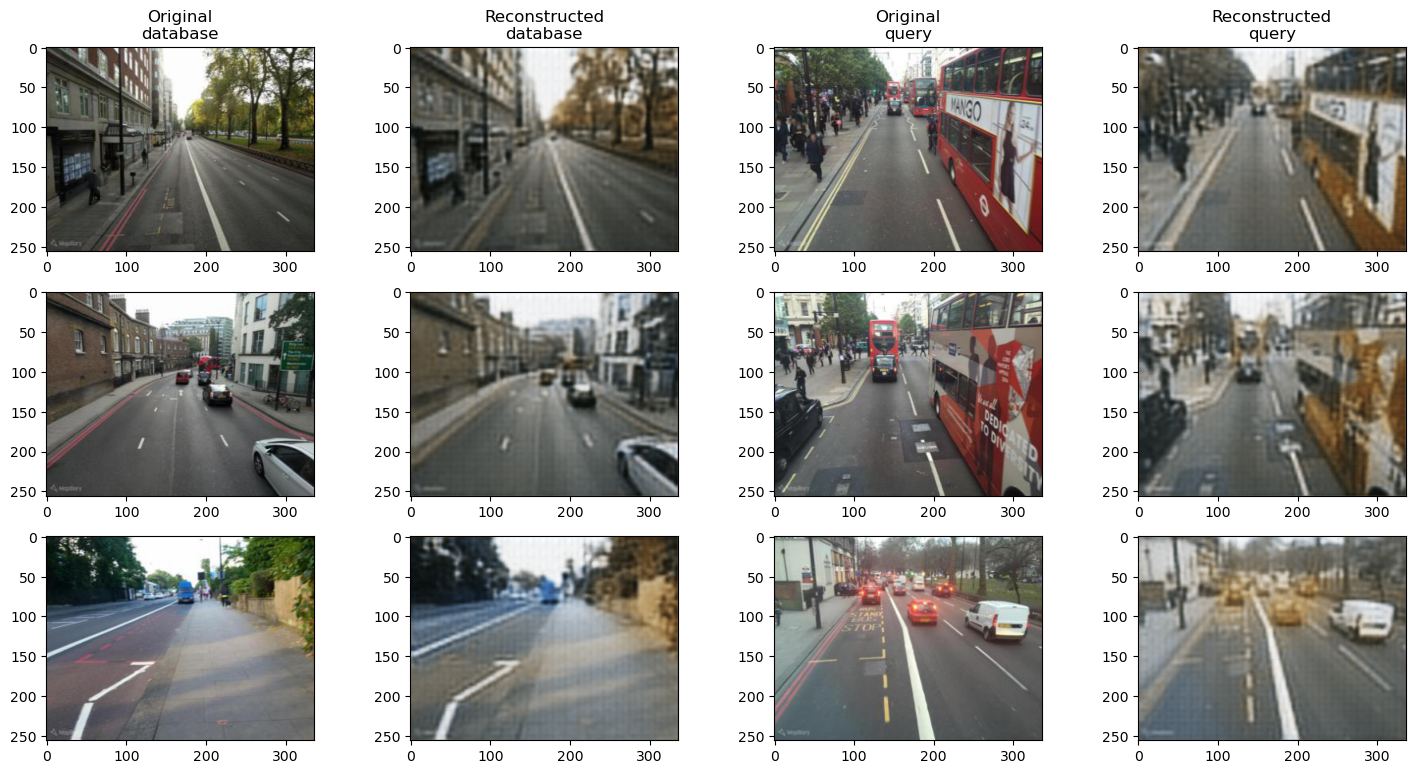

In [20]:
display_reconstructed_images(autoencoder, database_images, query_images)

### 5. Encode images and store encodings

In [21]:
def store_encoded_images(encoder, images, dataset_name):
    images_no = images.shape[0]
    encoded_images = encoder.predict(images).reshape(images_no, -1)

    print(f"Storing encoded {dataset_name} images. Dataset size: {encoded_images.shape}\n")

    with open(ENCODED_DATA_PATH + dataset_name + "_encoded.npy", "wb") as f:
        np.save(f, encoded_images)

In [22]:
store_encoded_images(encoder, database_images, "database_lite")
store_encoded_images(encoder, query_images, "query_lite")

32/32 [==============================] - 1s 41ms/step
Storing encoded database_lite images. Dataset size: (1000, 12768)

16/16 [==============================] - 1s 43ms/step
Storing encoded query_lite images. Dataset size: (500, 12768)



### 6. Load encoded images

In [23]:
def load_encoded_images(dataset_name):
    print(f"Loading encoded {dataset_name} images")

    with open(ENCODED_DATA_PATH + dataset_name + "_encoded.npy", "rb") as f:
        encoded_images = np.load(f)  

    return encoded_images

In [24]:
encoded_database_images = load_encoded_images("database_lite")
encoded_query_images = load_encoded_images("query_lite")

Loading encoded database_lite images
Loading encoded query_lite images
